## SuperStore Sales

#### Datasets
* https://data.world/bsullins/superstore

#### URLs
* https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
* https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
* https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-prophet-in-python-3
* https://facebook.github.io/prophet/

### Init

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
import string
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
# from pandas.plotting import register_matplotlib_converters
# import seaborn as sns
# from pylab import rcParams

# pd.options.display.float_format = '{:,.3f}'.format
# sns.set()

plt.rcParams['figure.figsize'] = 15,6
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'
# plt.style.use('fivethirtyeight')

### Data

In [2]:
df = pd.read_excel('.\datasets\sample_superstore_2018.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
Row ID           9994 non-null int64
Order ID         9994 non-null object
Order Date       9994 non-null datetime64[ns]
Ship Date        9994 non-null datetime64[ns]
Ship Mode        9994 non-null object
Customer ID      9994 non-null object
Customer Name    9994 non-null object
Segment          9994 non-null object
Country          9994 non-null object
City             9994 non-null object
State            9994 non-null object
Postal Code      9983 non-null float64
Region           9994 non-null object
Product ID       9994 non-null object
Category         9994 non-null object
Sub-Category     9994 non-null object
Product Name     9994 non-null object
Sales            9994 non-null float64
Quantity         9994 non-null int64
Discount         9994 non-null float64
Profit           9994 non-null float64
dtypes: datetime64[ns](2), float64(4), int64(2), object(13)
memory usage: 1.6

In [4]:
# Desde/Hasta del dataset
df['Order Date'].min(), df['Order Date'].max()

(Timestamp('2015-01-03 00:00:00'), Timestamp('2018-12-30 00:00:00'))

In [5]:
# Categorias disponibles
df['Category'].unique()

array(['Furniture', 'Office Supplies', 'Technology'], dtype=object)

In [6]:
# Reducimos el dataset a la fecha, categoria y ventas
df_sales = df[['Order Date', 'Category', 'Sales']].groupby(['Order Date', 'Category']).sum().reset_index()
df_sales.sort_values('Order Date', inplace=True)
df_sales.set_index('Order Date', inplace=True)
df_sales.head()

Category     Sales
Order Date                           
2015-01-03  Office Supplies    16.448
2015-01-04  Office Supplies   288.060
2015-01-05  Office Supplies    19.536
2015-01-06        Furniture  2573.820
2015-01-06  Office Supplies   685.340

In [7]:
# Agrupado por categoria hace un resample por mes y calcula el promedio
df_sales_resample = df_sales.groupby(['Category']).resample('MS').mean().reset_index().set_index('Order Date')

In [8]:
# Convierte los valores de Category en columnas
df_sales_pivot = pd.pivot_table(df_sales_resample, index='Order Date', values='Sales', columns=['Category'])
df_sales_pivot.head()

Category     Furniture  Office Supplies   Technology
Order Date                                          
2015-01-01  480.194231       285.357647   449.041429
2015-02-01  367.931600        63.042588   229.787143
2015-03-01  857.291529       391.176318  2031.948375
2015-04-01  567.488357       464.794750   613.028933
2015-05-01  432.049187       324.346545   564.698588

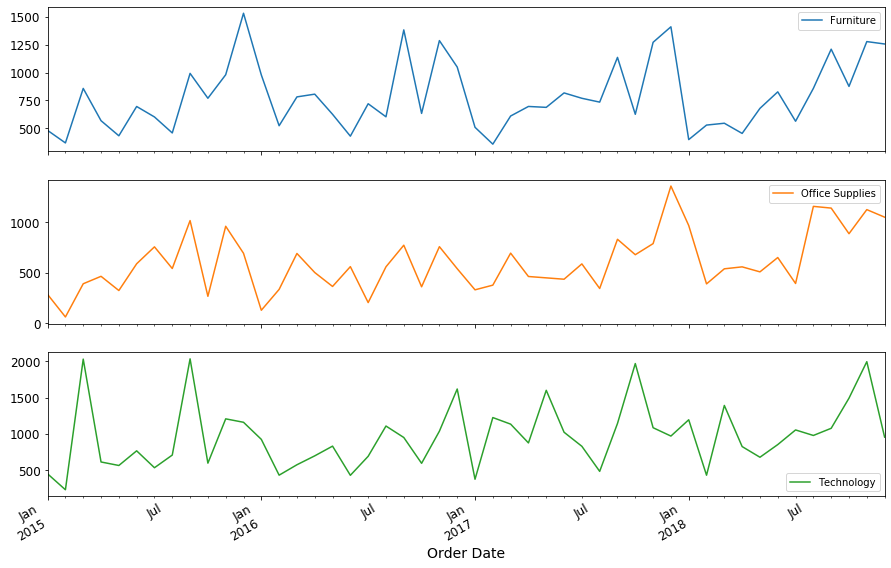

In [9]:
# Plot por categoria
df_sales_pivot.plot(subplots=True, figsize=(15, 10));

### Correlation

In [10]:
# Percentage of change
df_sales_pct = df_sales_pivot.pct_change()
df_sales_pct.head()

Category    Furniture  Office Supplies  Technology
Order Date                                        
2015-01-01        NaN              NaN         NaN
2015-02-01  -0.233786        -0.779075   -0.488272
2015-03-01   1.330030         5.204953    7.842742
2015-04-01  -0.338045         0.188198   -0.698305
2015-05-01  -0.238664        -0.302173   -0.078839

In [11]:
print('Correlation Furniture/Office: ', df_sales_pct['Furniture'].corr(df_sales_pct['Office Supplies']))
print('Correlation Furniture/Technology: ', df_sales_pct['Furniture'].corr(df_sales_pct['Technology']))
print('Correlation Office/Technology: ', df_sales_pct['Office Supplies'].corr(df_sales_pct['Technology']))

Correlation Furniture/Office:  0.47982653057493085
Correlation Furniture/Technology:  0.39900164891230544
Correlation Office/Technology:  0.7100986093493198


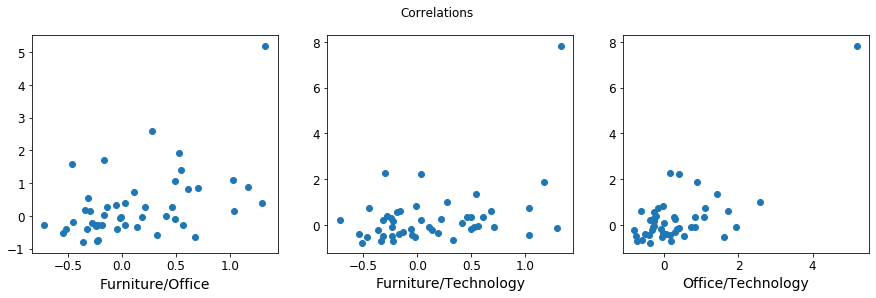

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
fig.suptitle('Correlations')
ax[0].scatter(df_sales_pct['Furniture'], df_sales_pct['Office Supplies'])
ax[0].set_xlabel('Furniture/Office')
ax[1].scatter(df_sales_pct['Furniture'], df_sales_pct['Technology'])
ax[1].set_xlabel('Furniture/Technology')
ax[2].scatter(df_sales_pct['Office Supplies'], df_sales_pct['Technology'])
ax[2].set_xlabel('Office/Technology');

### Autocorrelation

In [15]:
# PCT Autocorrelacion lag=1
print('PCT Autocorrelation Furniture: ', df_sales_pct['Furniture'].autocorr())
print('PCT Autocorrelation Technology: ', df_sales_pct['Technology'].autocorr())
print('PCT Autocorrelation Office: ', df_sales_pct['Office Supplies'].autocorr())
print('')

# Autocorrelacion lag=1
print('Autocorrelation Furniture: ', df_sales_pivot['Furniture'].autocorr())
print('Autocorrelation Technology: ', df_sales_pivot['Technology'].autocorr())
print('Autocorrelation Office: ', df_sales_pivot['Office Supplies'].autocorr())

PCT Autocorrelation Furniture:  -0.45195492802867687
PCT Autocorrelation Technology:  -0.26359218451940675
PCT Autocorrelation Office:  -0.3116206301948683

Autocorrelation Furniture:  0.24046529388752358
Autocorrelation Technology:  -0.05520172473592491
Autocorrelation Office:  0.32970232599446225


### Autocorrelation Function (ACF)

[ 1.          0.23099881  0.05845247  0.13740032 -0.20349439 -0.28971729
 -0.12144909 -0.28586549 -0.18564023  0.08071278 -0.08741769  0.09684871
  0.52286567  0.0509833   0.01080028  0.02623106 -0.20254521 -0.11591515
 -0.07048065 -0.17842959 -0.02266248  0.06287232 -0.07450286  0.17393977
  0.35262754  0.0255596   0.02904366 -0.04093169 -0.2250858  -0.08994644
 -0.0744134  -0.15727408  0.05120245  0.09348592 -0.04194728  0.15408845
  0.19551079  0.02997289  0.05716242  0.01179317 -0.09491623]


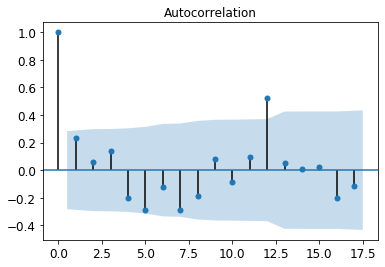

In [19]:
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

# ACF array
print(acf(df_sales_pivot['Furniture']))

# ACF plot
plot_acf(df_sales_pivot['Furniture'], alpha=0.05);

### Decomposing

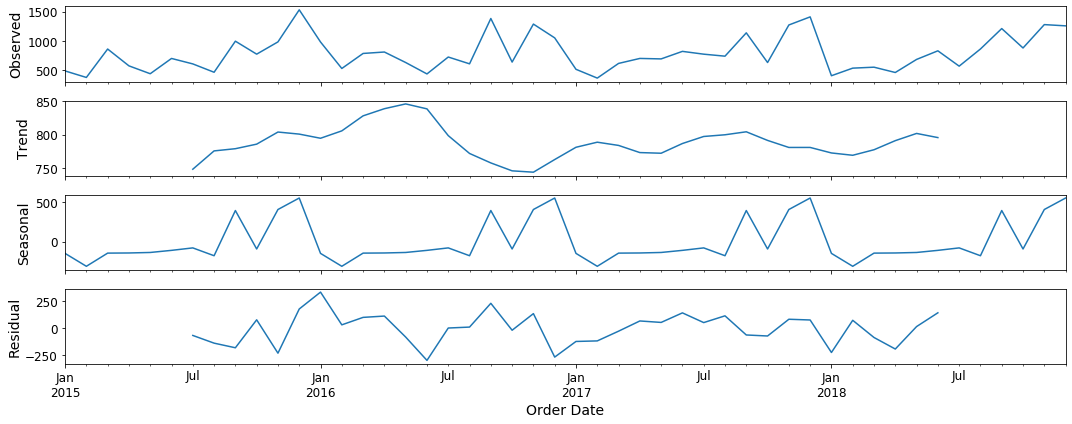

In [14]:
# Furniture
plt.rcParams['figure.figsize'] = 15,6
y = df_sales_pivot['Furniture']
decomposition = seasonal_decompose(y, model='additive')
fig = decomposition.plot()

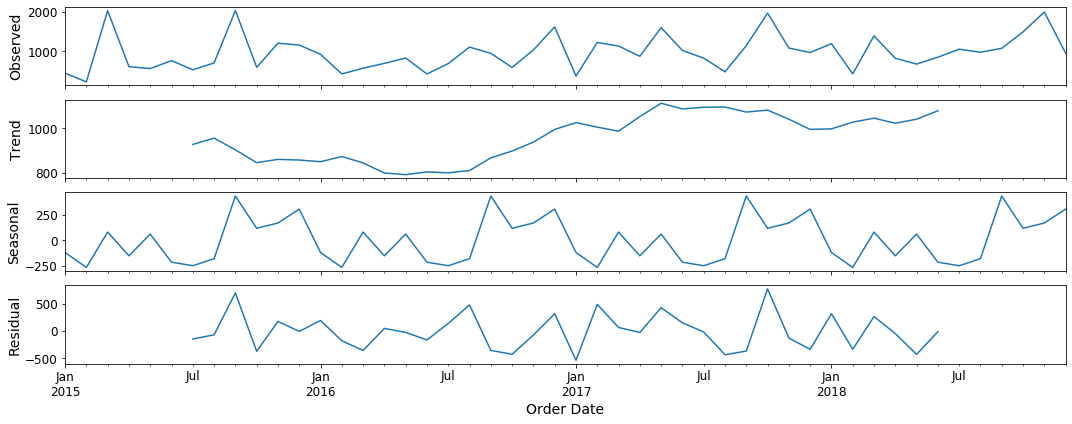

In [15]:
# Technology
plt.rcParams['figure.figsize'] = 15,6
y = df_sales_pivot['Technology']
decomposition = seasonal_decompose(y, model='additive')
fig = decomposition.plot()

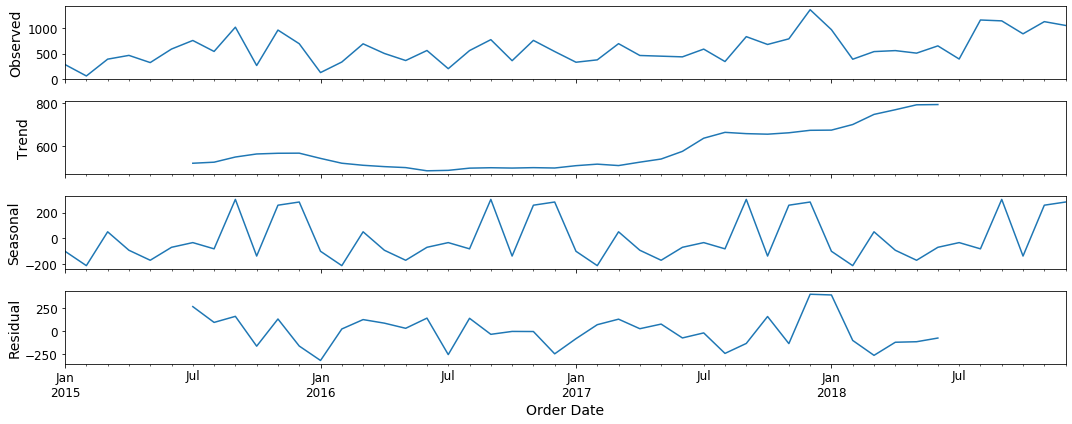

In [16]:
# Office Supplies
plt.rcParams['figure.figsize'] = 15,6
y = df_sales_pivot['Office Supplies']
decomposition = seasonal_decompose(y, model='additive')
fig = decomposition.plot()

### ARIMA

In [17]:
import itertools
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

y = df_sales_pivot['Furniture']

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 12) - AIC:769.0817523205916


C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppDa

ARIMA(0, 0, 0)x(0, 0, 1, 12) - AIC:1576.7324642473277
ARIMA(0, 0, 0)x(0, 1, 0, 12) - AIC:477.71701309202774
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:497.23144334183365


C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppDa

ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1478.1277236759956
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12) - AIC:720.9252270758104
ARIMA(0, 0, 1)x(0, 0, 1, 12) - AIC:2786.7230874852653
ARIMA(0, 0, 1)x(0, 1, 0, 12) - AIC:466.56074298091505


C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v_durand\AppDa

ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:499.59412606125284
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:2768.427220528199
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:319.98848769468674
ARIMA(0, 1, 0)x(0, 0, 0, 12) - AIC:677.894766843944


C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v_durand\AppDa

ARIMA(0, 1, 0)x(0, 0, 1, 12) - AIC:1378.5486237111134
ARIMA(0, 1, 0)x(0, 1, 0, 12) - AIC:486.63785671879367
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:497.78896630044073


C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppDa

ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1022.8611228052164
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:319.7714068109211
ARIMA(0, 1, 1)x(0, 0, 0, 12) - AIC:649.905617681726
ARIMA(0, 1, 1)x(0, 0, 1, 12) - AIC:3216.0197782079413
ARIMA(0, 1, 1)x(0, 1, 0, 12) - AIC:458.8705548482984
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:486.1832977442631

C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:2589.717123007444
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:310.7574368417452
ARIMA(1, 0, 0)x(0, 0, 0, 12) - AIC:692.1645522067713


C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v_durand\AppDa

ARIMA(1, 0, 0)x(0, 0, 1, 12) - AIC:1450.0255396955233
ARIMA(1, 0, 0)x(0, 1, 0, 12) - AIC:479.46321478521355
ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:480.92593679351836


C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:1352.209230823926
ARIMA(1, 0, 0)x(1, 1, 0, 12) - AIC:304.46646750845986
ARIMA(1, 0, 1)x(0, 0, 0, 12) - AIC:665.779444218529
ARIMA(1, 0, 1)x(0, 0, 1, 12) - AIC:2688.1953106578308


C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 0, 12) - AIC:468.3685195814159
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:482.57633238765646


C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v_durand\AppDa

ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:nan
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:306.01560022074426
ARIMA(1, 1, 0)x(0, 0, 0, 12) - AIC:671.2513547541902


C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v_durand\AppDa

ARIMA(1, 1, 0)x(0, 0, 1, 12) - AIC:1455.1241321469415
ARIMA(1, 1, 0)x(0, 1, 0, 12) - AIC:479.20034222811347
ARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:475.34036587849016


C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:1356.0287228411075
ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:300.62709013453934
ARIMA(1, 1, 1)x(0, 0, 0, 12) - AIC:649.0318019835137
ARIMA(1, 1, 1)x(0, 0, 1, 12) - AIC:21749.90908195544

C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)



ARIMA(1, 1, 1)x(0, 1, 0, 12) - AIC:460.4762687610251


C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:469.5250354660837
ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:2592.9586233250657

C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:297.787543953291


C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [18]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

C:\Users\v_durand\AppData\Local\Continuum\anaconda3\envs\mlchallenge\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


* **Histogram plus estimated density:** para validar que los residuales tienen una distribución normal standard con media 0 y desviación standard 1. 
* **Standarized residual:** no muestran una estacionalidad obvia y son como ruido blanco. Es un buen indicador.
* **Correlogram:** para verificar que los residuales no estan autocorrelacionados.
* **Normal Q-Q:** para verificar que la distribucion ordenada de residuales siguen una tendencia lineal. Buen indicador de que los residuales estan normalmente distribuidos.

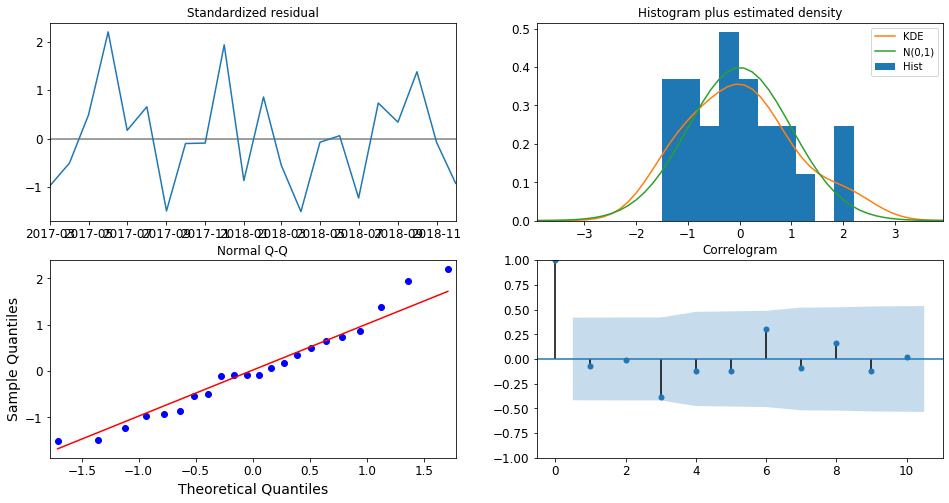

In [19]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

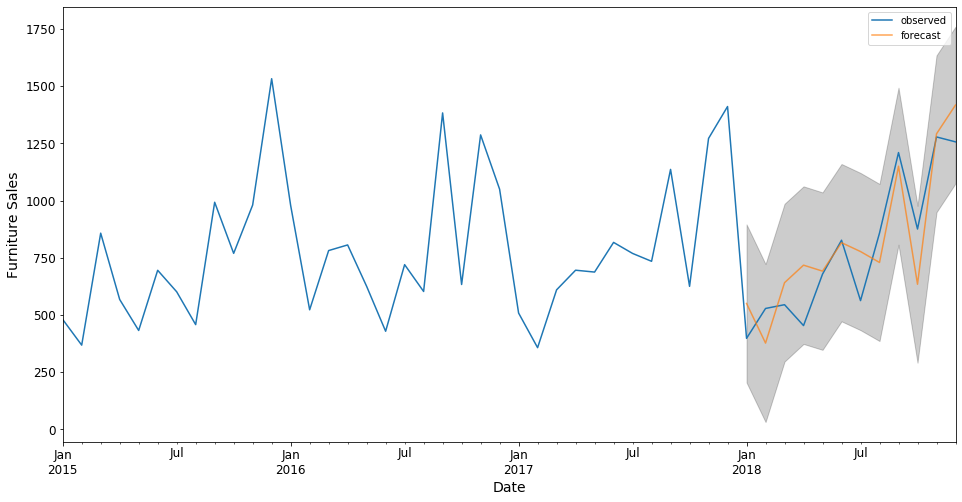

In [20]:
# VALIDACION
pred = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='forecast', alpha=.7, figsize=(16, 8))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend();

In [21]:
y_forecasted = pred.predicted_mean
y_truth = y['2018-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('Mean Squared Error: {}'.format(round(mse, 2)))
print('Root Mean Squared Error: {}'.format(round(np.sqrt(mse), 2)))

Mean Squared Error: 22993.57
Root Mean Squared Error: 151.64


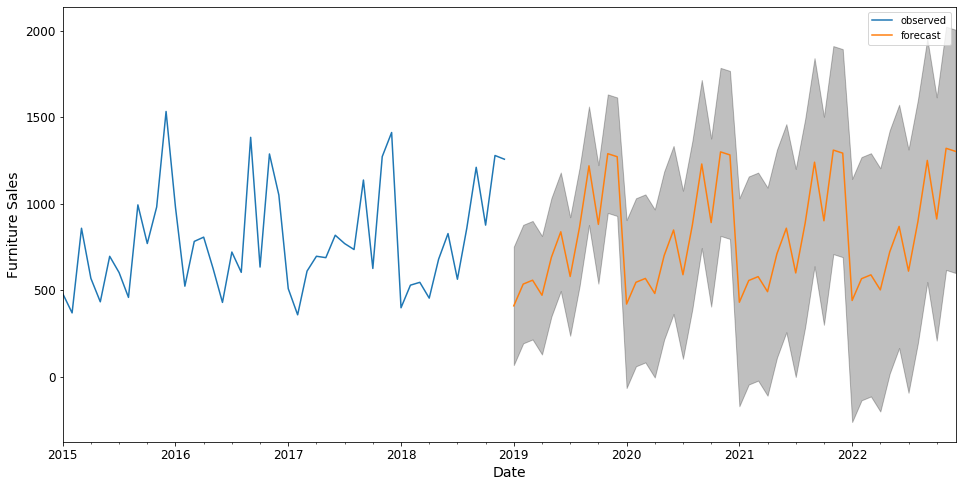

In [22]:
pred_uc = results.get_forecast(steps=48)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(16, 8))
pred_uc.predicted_mean.plot(ax=ax, label='forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend();

### Prophet forecasting

In [23]:
from fbprophet import Prophet

# Prophet requiere que la columna de fecha se llame 'ds' y la de resultado 'y'

# Furniture
furniture = df_sales_pivot[['Furniture']].reset_index().rename(columns={'Order Date': 'ds', 'Furniture': 'y'})
furniture_model = Prophet(interval_width=0.95) # intervalo de confidencia (.80 default)
furniture_model.fit(furniture) # fit del modelo
furniture_forecast = furniture_model.make_future_dataframe(periods=36, freq='MS') # genera dataframe con fechas futuras
furniture_forecast = furniture_model.predict(furniture_forecast) # predice las fechas que se genero en el paso anterior

# Office
office = df_sales_pivot[['Office Supplies']].reset_index().rename(columns={'Order Date': 'ds', 'Office Supplies': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


<Figure size 1296x432 with 0 Axes>

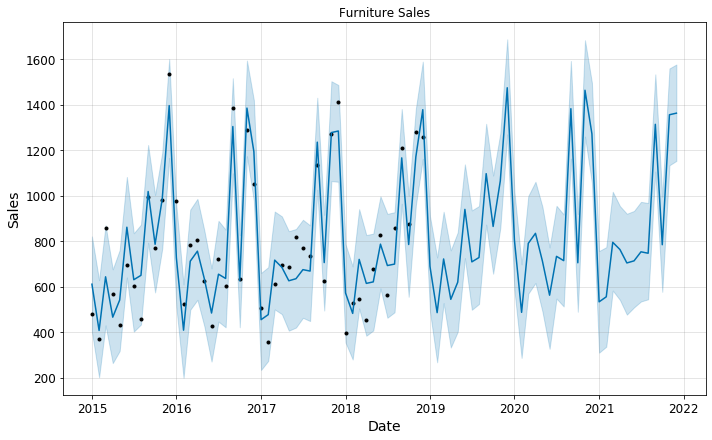

<Figure size 1296x432 with 0 Axes>

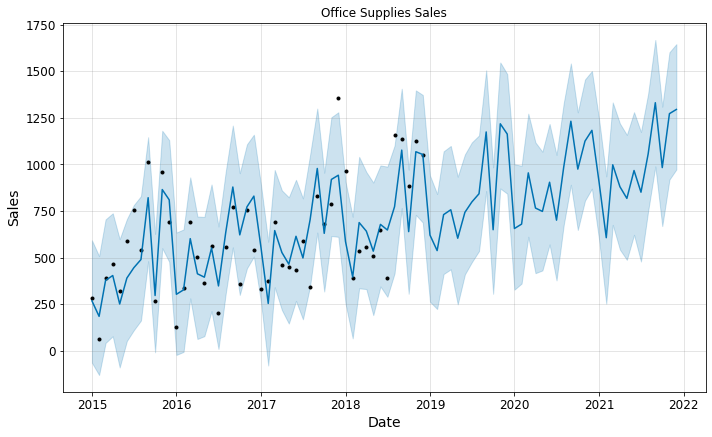

In [24]:
# Furniture plot
plt.figure(figsize=(18, 6))
furniture_model.plot(furniture_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Furniture Sales');

# Office plot
plt.figure(figsize=(18, 6))
office_model.plot(office_forecast, xlabel = 'Date', ylabel = 'Sales')
plt.title('Office Supplies Sales');

# Puntos negros: valores del dataset original
# Linea azul: forecast
# Region celeste: intervalos de confianza

#### Predicted values
* **ds:** the datestamp of the forecasted value
* **yhat:** the forecasted value of our metric
* **yhat_lower:** the lower bound of our forecasts
* **yhat_upper:** the upper bound of our forecasts

In [25]:
display(furniture_forecast.tail())
display(office_forecast.tail())

ds       trend   yhat_lower   yhat_upper  trend_lower  trend_upper  \
79 2021-08-01  866.372744   544.331113   967.304263   866.364326   866.381929   
80 2021-09-01  868.035188  1105.550013  1532.478425   868.026498   868.044679   
81 2021-10-01  869.644005   576.952494   994.944404   869.634816   869.653801   
82 2021-11-01  871.306449  1133.076645  1558.512320   871.296812   871.316681   
83 2021-12-01  872.915265  1152.379816  1575.804454   872.905052   872.925931   

    additive_terms  additive_terms_lower  additive_terms_upper      yearly  \
79     -119.757374           -119.757374           -119.757374 -119.757374   
80      444.982763            444.982763            444.982763  444.982763   
81      -85.643748            -85.643748            -85.643748  -85.643748   
82      483.828240            483.828240            483.828240  483.828240   
83      489.112489            489.112489            489.112489  489.112489   

    yearly_lower  yearly_upper  multiplicative_terms  \
79   -119.757374   -119.757374                   0.0   
80    444.982763    444.982763                   0.0   
81    -85.643748    -85.643748                   0.0   
82    483.828240    483.828240                   0.0   
83    489.112489    489.112489                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper         yhat  
79                         0.0                         0.0   746.615370  
80                         0.0                         0.0  1313.017951  
81                         0.0                         0.0   784.000257  
82                         0.0                         0.0  1355.134689  
83                         0.0                         0.0  1362.027754

ds        trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
79 2021-08-01  1036.666090  750.601548  1379.296570  1036.665753  1036.666447   
80 2021-09-01  1044.145825  989.718246  1667.581022  1044.145474  1044.146196   
81 2021-10-01  1051.384279  669.663068  1309.707555  1051.383913  1051.384668   
82 2021-11-01  1058.864014  919.059458  1601.471881  1058.863637  1058.864423   
83 2021-12-01  1066.102467  973.496247  1645.097252  1066.102076  1066.102895   

    additive_terms  additive_terms_lower  additive_terms_upper      yearly  \
79       19.762799             19.762799             19.762799   19.762799   
80      287.008554            287.008554            287.008554  287.008554   
81      -67.985039            -67.985039            -67.985039  -67.985039   
82      213.580961            213.580961            213.580961  213.580961   
83      228.926565            228.926565            228.926565  228.926565   

    yearly_lower  yearly_upper  multiplicative_terms  \
79     19.762799     19.762799                   0.0   
80    287.008554    287.008554                   0.0   
81    -67.985039    -67.985039                   0.0   
82    213.580961    213.580961                   0.0   
83    228.926565    228.926565                   0.0   

    multiplicative_terms_lower  multiplicative_terms_upper         yhat  
79                         0.0                         0.0  1056.428890  
80                         0.0                         0.0  1331.154380  
81                         0.0                         0.0   983.399240  
82                         0.0                         0.0  1272.444975  
83                         0.0                         0.0  1295.029032

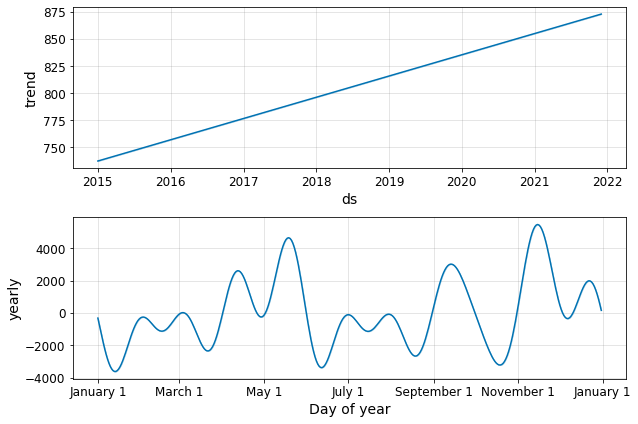

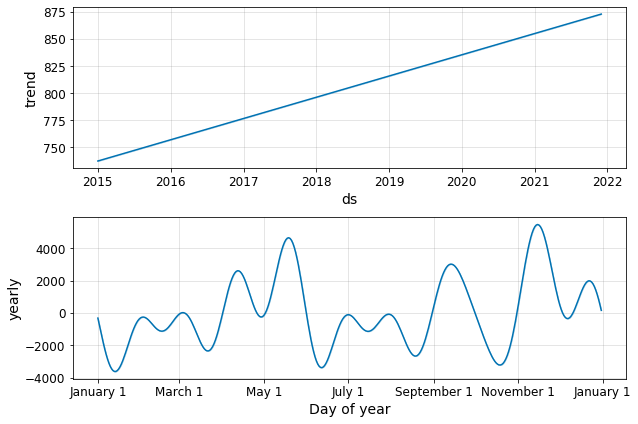

In [26]:
# Plot de componentes de Furniture
furniture_model.plot_components(furniture_forecast)

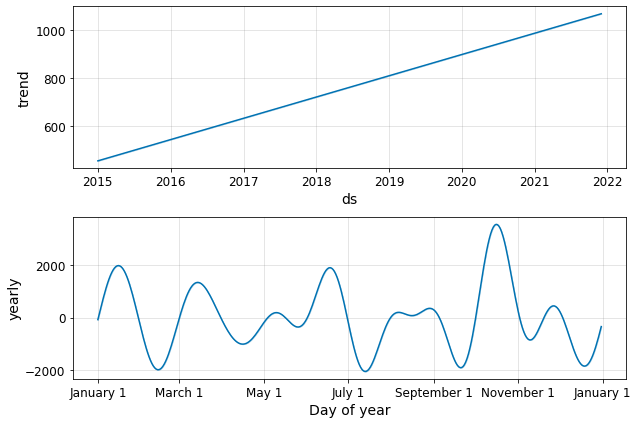

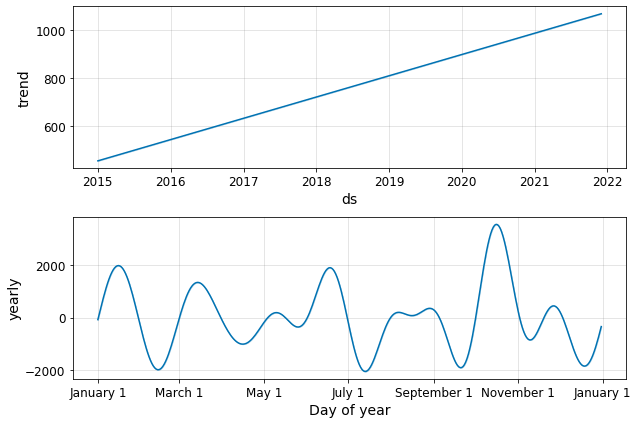

In [27]:
# Plot de componentes de Office
office_model.plot_components(office_forecast)